In [1]:
from afisp.stability_analysis import WorstSubsetFinder
from afisp.subgroup_phenotyping import SubgroupPhenotyper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import afisp.utils as utils
import pandas as pd
import subprocess

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Dataset

In [2]:
# from sklearn.datasets import load_breast_cancer
# seed = 1111
# np.random.seed(seed)
# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [3]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# binarize features
X = pd.get_dummies(df.iloc[:,:-1], dtype=int, drop_first=True)
X.columns = [''.join(x.split()).replace('-','_').replace('.','_') for x in X.columns]
y = (df.iloc[:, -1] == " >50K").astype(int)

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# Train model that we will evaluate

In [4]:
from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier
# model = LogisticRegression(max_iter=5000)
model = ExplainableBoostingClassifier(random_state=1234) #
model.fit(X_train, y_train)

ExplainableBoostingClassifier(random_state=1234)

In [5]:
test_preds = model.predict_proba(X_test)[:, -1]
print("Test AUROC = {}".format(roc_auc_score(y_test, test_preds)))

Test AUROC = 0.9266768866399566


# Gather subgroup characteristic data

In [6]:
# subgroup_features = ['Age', 'WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Race', 'Gender']
subgroup_features = [c for c in X_test.columns 
                     if 'Race' in c or 'Gender' in c or 'Age' in c]
print(subgroup_features)
subgroup_feature_data = X_test[subgroup_features].copy()
hinge_auc_loss = utils.torch_roc_auc_surrogate(y_test.to_numpy(), test_preds, 'hinge')
test_loss = hinge_auc_loss

['Age', 'Race_Asian_Pac_Islander', 'Race_Black', 'Race_Other', 'Race_White', 'Gender_Male']


# Perform stability Analysis

In [7]:
%%time
stability_analysis = WorstSubsetFinder(cv=10, verbose=True, eps=1e-5, subset_fractions=np.arange(0.05, 1, 0.05))
sa_risks = stability_analysis.fit(subgroup_feature_data.values, test_loss)

k = 0
k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
CPU times: user 2.01 s, sys: 93.3 ms, total: 2.11 s
Wall time: 12.6 s


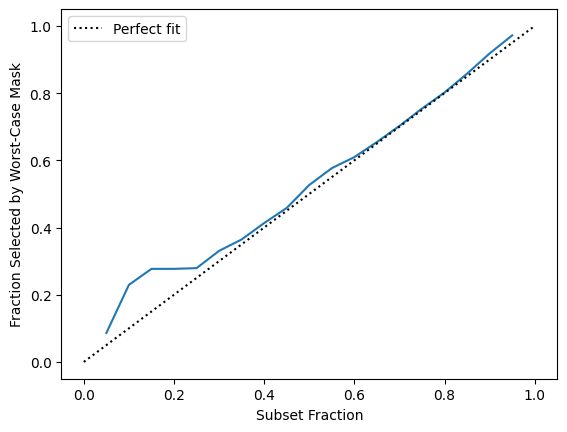

In [8]:
sa_masks = stability_analysis.subset_masks()
_ = stability_analysis.check_subset_sizes()

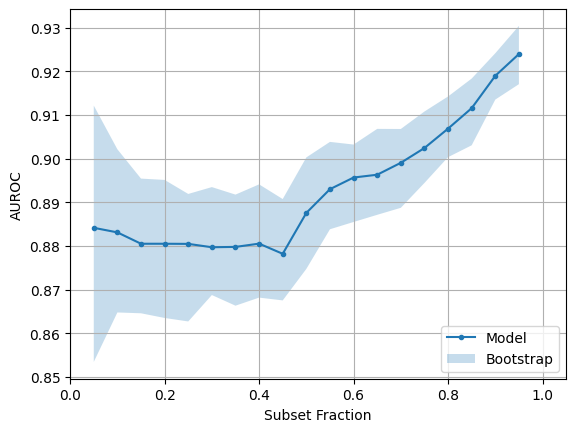

In [9]:
subpop_aucs = []
for m in sa_masks:
    subpop_aucs.append(roc_auc_score(y_test[m], test_preds[m]))
plt.plot(stability_analysis.subset_fractions, subpop_aucs, '.-', label='Model')
# compute bootstrap confidence intervals
bootstrap_cis = np.zeros_like(stability_analysis.confidence_intervals())
for i, alpha in enumerate(stability_analysis.subset_fractions):
    mask = sa_masks[i]
    mean, upper, lower = utils.bootstrap_ci(y_test[mask].values, 
                                            test_preds[mask], 
                                            loss=roc_auc_score)
    bootstrap_cis[i, 0] = lower
    bootstrap_cis[i, 1] = upper

plt.fill_between(stability_analysis.subset_fractions,
                 bootstrap_cis[:, 0], 
                 bootstrap_cis[:, 1], 
                 alpha=0.25, 
                 label='Bootstrap')

plt.ylabel('AUROC')
plt.xlabel('Subset Fraction')
plt.legend(loc='lower right')
plt.xlim(0, 1.05)
plt.grid()

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 [0.19689660172838946,
  0.19710576925657622,
  0.2008790866600582,
  0.2008790866600582,
  0.20023768461303154,
  0.20178810372966322,
  0.19891995586598402,
  0.1960025910152831,
  0.19912591234535015,
  0.16904132975701355,
  0.1500570562685197,
  0.1398538610701884,
  0.1342524970577572,
  0.12279892587362756,
  0.10696831587221028,
  0.08775700028695832,
  0.06698165581277525,
  0.035542093278357015,
  0.012540358039940129])

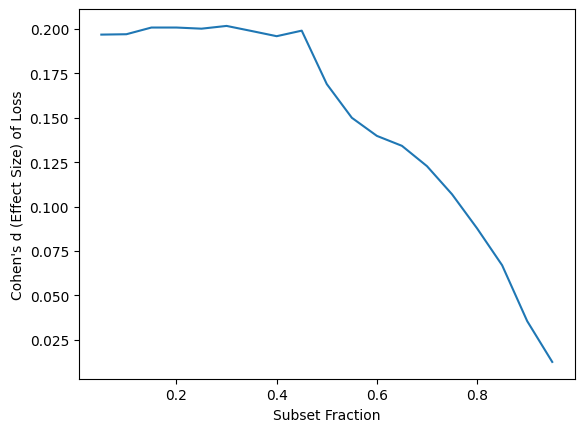

In [10]:
stability_analysis.compute_effect_sizes(plot=True)

In [11]:
max_ind, max_effect_size = stability_analysis.find_max_effect_size()
print(max_ind)

# Subgroup Phenotyping

In [12]:
subset_labels = sa_masks[max_ind]*1
sp = SubgroupPhenotyper()
extracted_rules = sp.fit(subgroup_feature_data, subset_labels, test_loss, depth=3, verbose=1, method="SIRUS")

Beginning call to SIRUS. If cv == True this may take a long time.
[1] 3
[1] "Number of trees:  1000  - Stability  90.78  %."
[1] "Number of trees:  2000  - Stability  93.02  %."
[1] "Number of trees:  3000  - Stability  94.46  %."
[1] "Number of trees:  4000  - Stability  95  %."
[1] "Number of trees:  5000  - Stability  95.25  %."
Finished call to SIRUS
Computing p-values


100%|██████████| 22/22 [00:00<00:00, 118.63it/s]


Effect size filtering


100%|██████████| 14/14 [00:00<00:00, 195.50it/s]


In [13]:
# Alternatively use DecisionList instead of SIRUS
sp.fit(subgroup_feature_data, subset_labels, test_loss, method="DecisionList", depth=3)

/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
100%|██████████| 11/11 [00:00<00:00, 214.70it/s]


[Age > 35.5 and Gender_Male > 0.5 and Race_Black <= 0.5,
 Age > 35.5 and Gender_Male > 0.5 and Race_White > 0.5,
 Age > 35.5 and Gender_Male > 0.5,
 Age <= 66.5 and Age > 35.5 and Race_Black <= 0.5]

In [14]:
extracted_rules

['Age >= 37 & Race_Black < 1 & Gender_Male >= 1',
 'Age >= 37 & Race_White >= 1 & Gender_Male >= 1',
 'Age >= 33']